In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
from scipy.stats import norm 

In [2]:
years = 15 

endDate = dt.datetime.now()

startDate = endDate - dt.timedelta(days = 365*years)

In [3]:
tickers = ['SPY', 'BND', 'GLD', 'QQQ', 'VTI']


In [4]:
#Download adjusted close prices

adj_close_df = pd.DataFrame()

for t in tickers:
    data = yf.download(t, start= startDate, end= endDate)
    adj_close_df[t] =  data['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [5]:
print(adj_close_df)

                   SPY        BND         GLD         QQQ         VTI
Date                                                                 
2008-10-08   72.975723  48.154270   89.419998   28.333376   36.723766
2008-10-09   67.879158  46.654274   89.900002   27.572346   34.417702
2008-10-10   66.232712  45.231926   83.220001   27.397394   33.422916
2008-10-13   75.849525  47.113384   81.989998   30.730213   37.711014
2008-10-14   74.726959  47.714626   82.199997   29.400581   37.386948
...                ...        ...         ...         ...         ...
2023-09-29  427.480011  69.587997  171.449997  358.269989  212.410004
2023-10-02  427.309998  69.110001  169.649994  361.260010  212.130005
2023-10-03  421.589996  68.550003  169.160004  354.920013  209.050003
2023-10-04  424.660004  69.000000  169.139999  359.750000  210.559998
2023-10-05  422.500000  69.079201  168.570007  357.000488  209.419296

[3774 rows x 5 columns]


In [6]:
#Calculate daily log returns and drop NA
#Drop NA as first row will be null

log_returns = np.log(adj_close_df/adj_close_df.shift(1))

log_returns = log_returns.dropna()

In [7]:
log_returns

,SPY,BND,GLD,QQQ,VTI
Date,,,,,
2008-10-09,-0.072398,-0.031645,0.005354,-0.027227,-0.064853
2008-10-10,-0.024555,-0.030961,-0.077210,-0.006365,-0.029329
2008-10-13,0.135577,0.040754,-0.014890,0.114798,0.120710
2008-10-14,-0.014911,0.012681,0.002558,-0.044232,-0.008631
2008-10-15,-0.103637,-0.006116,0.013413,-0.093823,-0.098197
...,...,...,...,...,...
2023-09-29,-0.002430,-0.000430,-0.010329,0.000726,-0.002915
2023-10-02,-0.000398,-0.006893,-0.010554,0.008311,-0.001319
2023-10-03,-0.013476,-0.008136,-0.002892,-0.017705,-0.014626


In [8]:
### Create a function that will be used to calculate portfolio expected return
#We are assuming that future returns are based on past returns, which is not a reliable assumption.
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)

### Create a function that will be used to calculate portfolio standard deviation
def standard_deviation (weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

In [9]:
### Create a covariance matrix for all the securities
cov_matrix = log_returns.cov()
print(cov_matrix)

              SPY           BND       GLD           QQQ           VTI
SPY  1.606648e-04  6.068687e-07  0.000011  1.652181e-04  1.616179e-04
BND  6.068687e-07  1.042667e-05  0.000009  3.997657e-07  5.678233e-07
GLD  1.063265e-05  8.701201e-06  0.000110  1.003227e-05  1.139557e-05
QQQ  1.652181e-04  3.997657e-07  0.000010  1.978876e-04  1.671901e-04
VTI  1.616179e-04  5.678233e-07  0.000011  1.671901e-04  1.642720e-04


In [10]:
### Create an equally weighted portfolio and find total portfolio expected return and standard deviation
portfolio_value = 1000000
weights = np.array([1/len(tickers)]*len(tickers))
portfolio_expected_return = expected_return(weights, log_returns)
portfolio_std_dev = standard_deviation (weights, cov_matrix)

In [11]:
def random_z_score():
    return np.random.normal(0, 1)

### Create a function to calculate scenarioGainLoss
days = 20

def scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days):
    return portfolio_value * portfolio_expected_return * days + portfolio_value * portfolio_std_dev * z_score * np.sqrt(days)

In [12]:
### Run 10000 simulations
simulations = 10000
scenarioReturn = []

for i in range(simulations):
    z_score = random_z_score()
    scenarioReturn.append(scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days))

In [13]:
### Specify a confidence interval and calculate the Value at Risk (VaR)
confidence_interval = 0.99
VaR = -np.percentile(scenarioReturn, 100 * (1 - confidence_interval))
print(VaR)

81029.01969888243


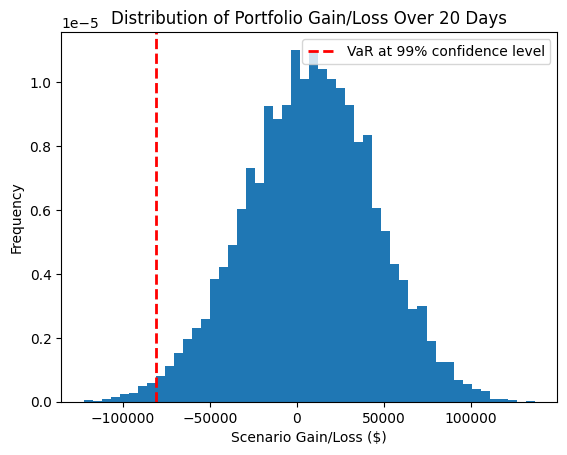

In [14]:
### Plot the results of all 10000 scenarios
plt.hist(scenarioReturn, bins=50, density=True)
plt.xlabel('Scenario Gain/Loss ($)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio Gain/Loss Over {days} Days')
plt.axvline(-VaR, color='r', linestyle='dashed', linewidth=2, label=f'VaR at {confidence_interval:.0%} confidence level')
plt.legend()
plt.show()